# "Приоритизация гипотез и проведение A/B-теста для интернет-магазина" <a class="tocSkip">

## Цель исследования

<div style="border: ridge black 3px; padding: 25px">
    
<b>Целью данного исследования является приоритизация сформулированных гипотез отделом маркетинга и последующий анализ результатов А/B-теста по выбранной гипотезе, направленной на увеличение выручки интернет-магазина.</b>
    
</div>

## Описание исходных данных

**Ниже представлено описание всей доступной нам информации по трём представленным файлам с датасетами (с указанными путями доступа).**

**Файл `/datasets/hypothesis.csv`** (содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort):

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Файл `/datasets/orders.csv`** (содержит данные с результатами A/B-теста):

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ; 
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

**Файл `/datasets/visitors.csv`** (содержит данные с результатами A/B-теста):

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Открытие данных

In [1]:
# импортируем основные нужные библиотеки для будущих манипуляций

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import datetime as dt

In [2]:
# присвоим каждому (из 3-х) датафреймов одноименные названия

hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Из исходных данных сразу видно, что присутствует разный регистр у названий столбцов в файле `hypothesis.csv` (датафрейм `hypothesis`). Приведем названия столбцов к единому регистру и переименуем методом `.rename()`некоторые из столбцов датафрейма `orders` для удобства понимания в дальнейших манипуляциях.

In [3]:
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename({'transactionId': 'orderId', 'visitorId': 'userId'}, axis = 'columns')

In [4]:
# используя цикл, посмотрим сразу на общую информацию по каждой таблице и выведем на экран содержимое 
# первых 10 строк, а также градиентом наличие/отсутствие пропусков:

hypothesis.name = 'Таблица "9 гипотез по увеличению выручки интернет-магазина"' # дадим названия каждой из таблиц для удобства
orders.name = 'Таблица "Информация о заказах: результат A/B - теста"'
visitors.name = 'Таблица "Информация о посетителях: результат A/B - теста"'


for data in [hypothesis, orders, visitors]:
    print(data.name)
    print('--------------------------------------------------------------------------------------------------------------')
    print(data.info())
    display(data.head(10))
    print('Кол-во пропусков')
    display(pd.DataFrame((data.isna().mean()*100).round(2)).style.background_gradient('coolwarm'))
    print('--------------------------------------------------------------------------------------------------------------')
    print()                                                        

Таблица "9 гипотез по увеличению выручки интернет-магазина"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Кол-во пропусков


,0
hypothesis,0
reach,0
impact,0
confidence,0
efforts,0


--------------------------------------------------------------------------------------------------------------

Таблица "Информация о заказах: результат A/B - теста"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
orderId    1197 non-null int64
userId     1197 non-null int64
date       1197 non-null object
revenue    1197 non-null int64
group      1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


Кол-во пропусков


,0
orderId,0
userId,0
date,0
revenue,0
group,0


--------------------------------------------------------------------------------------------------------------

Таблица "Информация о посетителях: результат A/B - теста"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Кол-во пропусков


,0
date,0
group,0
visitors,0


--------------------------------------------------------------------------------------------------------------



### Вывод

<div style="border:solid black 2px; padding: 20px">
    
При открытии данных мы скорректировали некоторые названия столбцов, привели к нижнему единому регистру названия столбцов датафрейма `hypothesis`.<br>
Все 3 датафрейма пропусков не имеют.<br>
При чтении общей информации по каждому из 3-х датафреймов мы обнаружили следующие моменты, требующие коррекции:<br><br>
- Датафрейм <b>`orders`</b>: столбец `'date'` необходимо перевести из типа  <i>object</i> в тип <i>datetime</i>.<br>
- Датафрейм <b>`visitors`</b>: столбец `'date'` также необходимо перевести из типа <i>object</i> в тип <i>datetime</i>.<br><br>
    
Далее приступим к изменению типов данных.
</div>

## Предобработка данных

### Изменение типов данных

In [5]:
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y-%m-%d')

# проверяем успешность изменений
for data in [orders, visitors]:
    print('--------------------------------------------------------------------------------------------------------------')
    print(data.name)
    print('--------------------------------------------------------------------------------------------------------------')
    print(data.info())

--------------------------------------------------------------------------------------------------------------
Таблица "Информация о заказах: результат A/B - теста"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
orderId    1197 non-null int64
userId     1197 non-null int64
date       1197 non-null datetime64[ns]
revenue    1197 non-null int64
group      1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
--------------------------------------------------------------------------------------------------------------
Таблица "Информация о посетителях: результат A/B - теста"
--------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 column

Изменение типов данных выполнили, проверим наличие грубых дубликатов в датафреймах.

In [6]:
# с помощью цикла выполним проверку по всем таблицам

for data in [hypothesis, orders, visitors]:
    duplicated_found = data.duplicated().sum()
    if duplicated_found > 0:
        print('Количество дубликатов в {} = '.format(data.columns.values), end='')
        print(duplicated_found)
    else:
        print('Дубликатов в {} не найдено'.format(data.columns.values))

Дубликатов в ['hypothesis' 'reach' 'impact' 'confidence' 'efforts'] не найдено
Дубликатов в ['orderId' 'userId' 'date' 'revenue' 'group'] не найдено
Дубликатов в ['date' 'group' 'visitors'] не найдено


### Вывод

<div style="border:solid black 2px; padding: 20px">
    
Мы выполнили необходимую предобработку данных: скорректировали типы данных, проверили наличие дубликатов.
Можем приступить к приоритизации гипотез.

</div>

## Приоритизация гипотез

In [7]:
pd.options.display.max_colwidth = 200  # применим данный метод для последующего отображения всего содержимого строк

# в частности нас интересует полное содержимое столбца `hypothesis`

### Фреймворк ICE 

In [8]:
# применим фреймворк ICE 
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

# и выведем по убыванию итоговые значения ICE по каждой гипотезе
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


<div style="border:dotted black 3px; padding: 20px">
    
Видим, что в ТОП-3 согласно фреймворку ICE гипотез входят следующие гипотезы:<br><br>
    
<b>1) Запустить акцию, дающую скидку на товар в день рождения	(ICE = 16.2, `индекс 8`)</b><br>
    
2) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (ICE = 13.3, `индекс 0`)<br>
    
3) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (ICE = 11.2, `индекс 7`)<br>	
    
</div>

###  Фреймворк RICE 

В данных есть параметр Reach, поэтому используем теперь RICE и сравним результаты с  фреймворком ICE.

In [9]:
# рассчитываем RICE 
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

# и выведем по убыванию итоговые значения RICE по каждой гипотезе
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод

<div style="border:dotted black 3px; padding: 20px">
    
По фреймворку RICE лидирующая гипотеза с большим отрывом от остальных гипотез звучит как <b>"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (RICE = 112.0, `индекс 7`).</b><br><br>
    
Данный отрыв связан с тем, что у данной гипотезы параметр Reach = 10 (это максимальный показатель параметра из всех представленных).<br>
<hr>
Если сравнивать с ТОП-3 гипотезами по фреймворку ICE, то наблюдаются 2 общие гипотезы (с `индексом 7`, и `индексом 0`), но с разным порядком приоритета. Благодаря параметру Reach итоговый порядок поменялся и гипотеза с `индексом 7` заняла лидирующую позицию по фреймворку RICE.<br><br>
    
Гипотеза же с `индексом 8` (ТОП-1 по фреймворку ICE) по фреймворку RICE сместилась на 5 место из-за слишком маленького параметра Reach = 1, означающего минимальный охват пользователей, которых бы затронуло данное изменение согласно гипотезе.<br><br>

<b>Т.к. в наших данных есть параметр Reach, следует полагаться на результат RICE оценки.</b>
    
</div>

## Анализ A/B-теста

Для анализа и дальнейшего построения графиков нам необходимо собрать кумулятивные данные. 

Создадим датафрейм `cumulativeData` со следующими столбцами:

- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
- `buyers` — кумулятивное количество покупателей (совершивших хотя бы 1 заказ) на указанную дату в указанной группе;
- `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- `visitors` — кумулятивное количество пользователей/посетителей интернет-магазина на указанную дату в определённой группе.

Для этого в несколько шагов осуществим следующие операции.

In [10]:
# Создаем массив уникальных пар значений дат и групп теста `datesGroups`

datesGroups = orders[['date','group']].drop_duplicates() 

# Создаем `ordersAggregated`, в котором соберем агрегированные данные о заказах:

# 1) с помощью функции` np.logical_and()` получим строки из таблицы `orders`, соответствующие нужному нам двойному условию
# 2) вычислим max-дату, найдем число уникальных ID заказов и пользователей, подсчитаем сумму средних чеков
# 3) с помощью `.apply(axis=1)` применим методы к каждой строке дф
# 4) и отсортируем результаты по столбцам 'date' и 'group'

ordersAggregated = datesGroups \
.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])] \
.agg({'date' : 'max', 'group' : 'max', 'orderId' : pd.Series.nunique, 'userId' : pd.Series.nunique, 'revenue' : 'sum'}), \
axis=1).sort_values(by=['date','group']) 

# Аналогично создаем `visitorsAggregated`, в котором соберем агрегированные данные о посетителях:

visitorsAggregated = datesGroups \
.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

print()
print('Таблица "ordersAggregated"')
display(ordersAggregated.head())
print('----------------------------------------------------------------------------------------------------------------------')
print('Таблица "visitorsAggregated"')
display(visitorsAggregated.head())


Таблица "ordersAggregated"


,date,group,orderId,userId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


----------------------------------------------------------------------------------------------------------------------
Таблица "visitorsAggregated"


,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


С помощью `.merge()` объединим обе таблицы в одну - `cumulativeData`. И дадим актуальные понятные названия столбцам.

In [11]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

### График кумулятивной выручки

Построим график кумулятивной выручки по дням и группам.

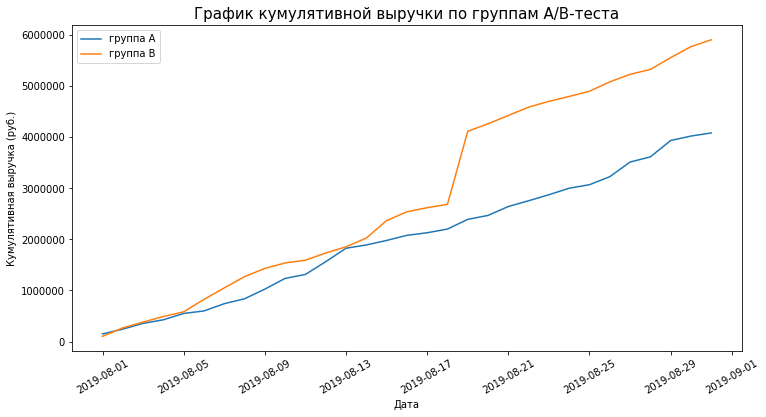

In [12]:
import warnings
warnings.filterwarnings('ignore')

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# строим график выручки группы А
plt.figure(figsize=(12,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='группа A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='группа B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка (руб.)')
plt.title('График кумулятивной выручки по группам А/B-теста', fontsize=15)
plt.tick_params(axis='x', labelrotation=30)
plt.legend() 

plt.show()
import warnings
warnings.filterwarnings('ignore')

<div style="border:dotted black 3px; padding: 20px">
    
По данному графику видно, что в начале теста обе группы шли примерно на одинаковых показателях выручки до 05 Августа 2019. 13 Августа 2019 наблюдается дновременное достижение одинакового показателя выручки. Группа B в целом показывает лучший рост выручки по сравнению с группой А.<br><br>
    
18 Августа 2019 визуально можо зафиксировать всплеск выручки группы B. И всего за 1 день уже 19 Августа 2019 прирост выручки составил более 1 000 000 руб. Это похоже на выброс и может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов/заказа.<br>
     
</div>

### График кумулятивного среднего чека

Построим графики среднего чека по группам: разделим кумулятивную выручку на кумулятивное число заказов.

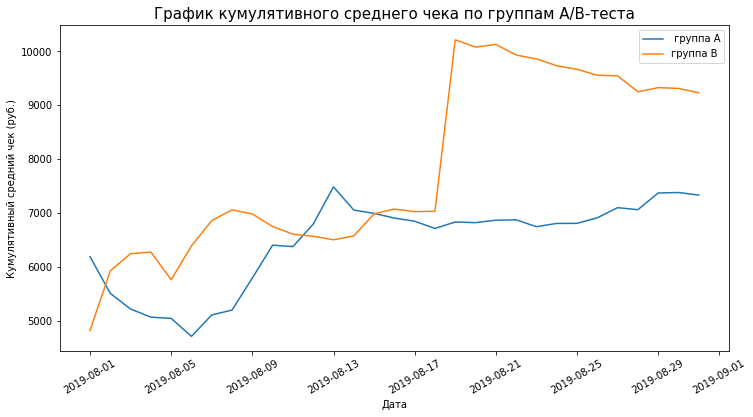

In [13]:
# строим график среднего чека группы А
plt.figure(figsize=(12,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label=' группа A')

# строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='группа B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек (руб.)')
plt.title('График кумулятивного среднего чека по группам А/B-теста', fontsize=15)
plt.tick_params(axis='x', labelrotation=30)
plt.legend() 

plt.show() 

<div style="border:dotted black 3px; padding: 20px">
    
По данному графику видно, что <b>в начале теста средний чек в группе B имел наибольшие показатели</b> и тенденцию к росту по сравнению с группой А.<br><br>

Но, стоит отметить, что в группе А (без учета начальных дней теста) наблюдался постепенный рост среднего чека и после пика показателя - 13 Августа 2019 - уровень ср.чека стабилизировался примерно на одном уровне.<br><br>

Замечено небольшое падение ср.чека группы B - 9 Августа 2019.<br><br>

Но, как мы уже заметили ранее - 18 Августа 2019 случился всплеск - скорее всего, крупный заказ (средний чек увеличился с 7000 руб. до 10000 руб. с небольшим).<br>
<hr>
<b>И к концу теста группа B по итогу лидирует (за счет этого всплеска)</b>, хотя тенденция после всплеска в группе B направлена на спад ср.чека.<br><br>
    
Далее построим подробнее графики относительного изменения кумулятивного ср.чека группы B к группе А.
    
</div>

###  График относительного изменения кумулятивного среднего чека

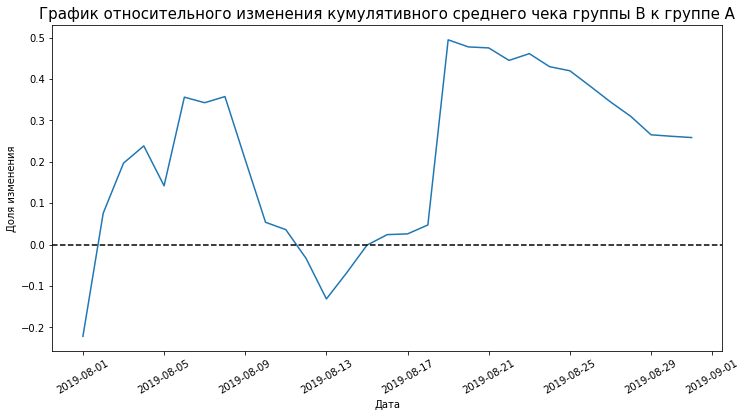

In [14]:
# соберем  данные в один датафрейм `mergedCumulativeRevenue`

mergedCumulativeRevenue = cumulativeRevenueA \
.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим график относительного различия кумулятивного среднего чека группы B к группе A

plt.figure(figsize=(12,6))
plt.plot(mergedCumulativeRevenue['date'], \
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/ \
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.xlabel('Дата')
plt.ylabel('Доля изменения')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', fontsize=15)
plt.tick_params(axis='x', labelrotation=30)
plt.axhline(y=0, color='black', linestyle='--')  # добавим ось X
plt.show()

<div style="border:dotted black 3px; padding: 20px">
    
По данному графику видно, что есть несколько выраженных точек всплесков и падений. Это свидетельствует о крупных заказах и выбросах, несмотря на лидирующее положение группы B по кумулятивному среднему чеку.<br><br>
    
Учтем необходимость учета выбросов при дальнейшей оценке.
    
</div>

###  График кумулятивной конверсии

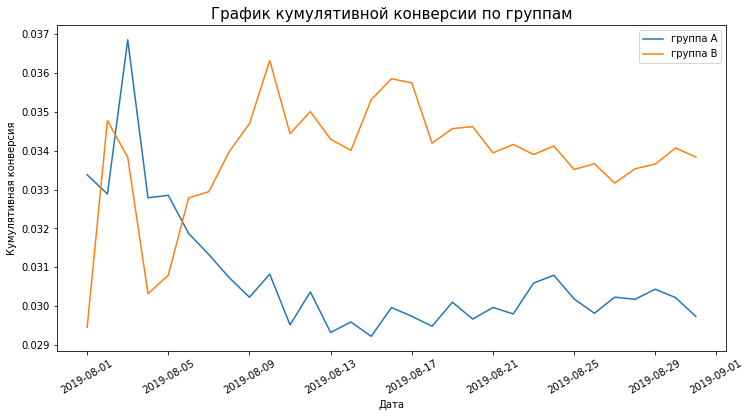

In [15]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='группа B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.title('График кумулятивной конверсии по группам', fontsize=15)
plt.tick_params(axis='x', labelrotation=30)
plt.legend()
plt.show()

<div style="border:dotted black 3px; padding: 20px">
    
По данному графику видно, что в самом начале теста в обеих группах конверсия сильно колебалась, но затем уже <b>после 09 Августа 2019 конверсия группы B вырвалась вперед и до конца теста зафиксировалась на лидирующей позиции.</b><br><br>
    
Конверсия же группы А также зафиксировалась, но, наоборот - просела по показателю. 
     
</div>

###  График относительного изменения кумулятивной конверсии

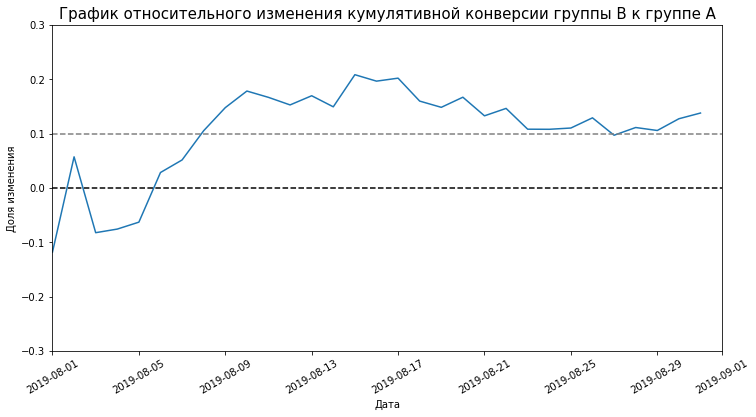

In [16]:
# объединим 2 дф с конверсиями групп А и B, соответственно, в один датафрейм `mergedCumulativeConversions` 
# выбираем 2 столбца с датой и конверсией и объединяем по дате
mergedCumulativeConversions = \
cumulativeDataA[['date','conversion']] \
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# строим график 
plt.figure(figsize=(12,6))
plt.plot(mergedCumulativeConversions['date'], \
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.xlabel('Дата')
plt.ylabel('Доля изменения')
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', fontsize=15)
plt.tick_params(axis='x', labelrotation=30)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.10, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.30, 0.30]) # изменим масштаб для наглядности, задав границы Y между -0.30 и 0.30
plt.show()

<div style="border:dotted black 3px; padding: 20px">
    
По данному графику видно, что в самом начале теста были колебания кумулятивной конверсии, затем наблюдается устойчивый рост.<br><br>
    
И на протяжении периода с 08 Августа 2019 до конца теста 31 Августа 2019 <b>прирост кумулятивной конверсии группы B к группе А не падал ниже 10%</b> (иногда достигая 15%).<br><br>
    
А также <b>к концу теста заметна тенденция на рост конверсии группы B</b> к группе А.
     
</div>

### Гистограмма и график разброса количества заказов по пользователям

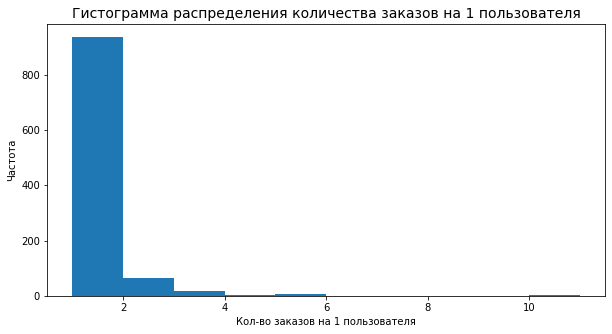

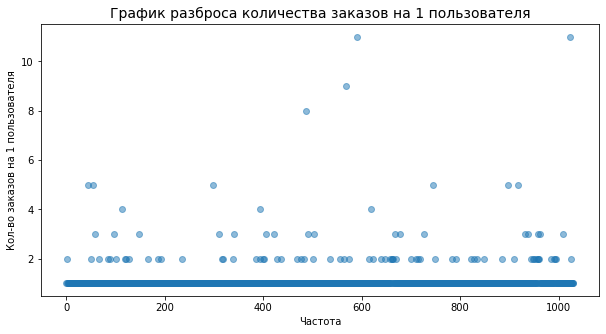

In [17]:
# создадим датафрейм `ordersByUsers`:
# группируем по каждому пользователю и найдем кол-во сделанных уникальных заказов

ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1) \
.groupby('userId', as_index=False) \
.agg({'orderId': pd.Series.nunique})

ordersByUsers.columns = ['userId', 'orders']

# строим гистограмму распределения кол-ва заказов на 1 пользователя

plt.figure(figsize=(10,5))
plt.hist(ordersByUsers['orders'])
plt.ylabel('Частота')
plt.xlabel('Кол-во заказов на 1 пользователя')
plt.title('Гистограмма распределения количества заказов на 1 пользователя', fontsize=14)
plt.show()

pd.set_option('float_format', '{:f}'.format)
orders['revenue'].describe()

# а также строим график разброса 

x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5) 
plt.ylabel('Кол-во заказов на 1 пользователя')
plt.xlabel('Частота')
plt.title('График разброса количества заказов на 1 пользователя', fontsize=14)
plt.show()

<div style="border:dotted black 3px; padding: 20px">
    
По данным графикам мы видим, что основная масса пользователей делают по 1 заказу. И значительно реже - по 2 заказа.<br><br>
    
3 и более заказов - уже аномальные ситуации. Но для точного отсечения аномальных пользователей в пределах 1%-5% наблюдений от общей массы нам необходимо рассчитать перцентили.
     
</div>

### 95-й и 99-й перцентили количества заказов на пользователя

In [18]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

<div style="border:dotted black 3px; padding: 20px">
    
**Не более 5% пользователей оформляли по 2 заказа и 1% пользователей оформляли 4 заказа**. 
    
Но включать границу и отсеивать пользователей с 2 заказами мы не можем, поскольку мы берем во внимание гистограмму распределения и график разброса, которые визуально указывают на редкие, но не аномальные заказы (несмотря на 95 перцентиль). 
    
Будем считать границей для отсеивания - пользователей с 3 и более заказами. 
    
</div>

### Гистограмма и график разброса стоимостей заказов

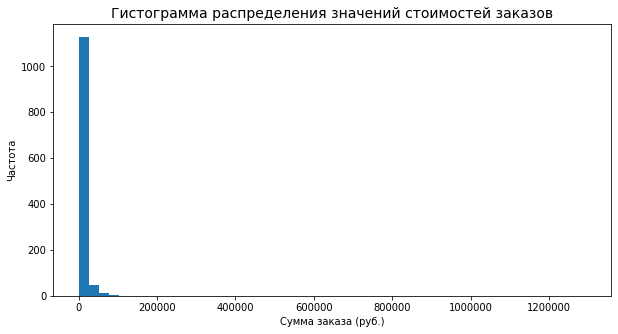

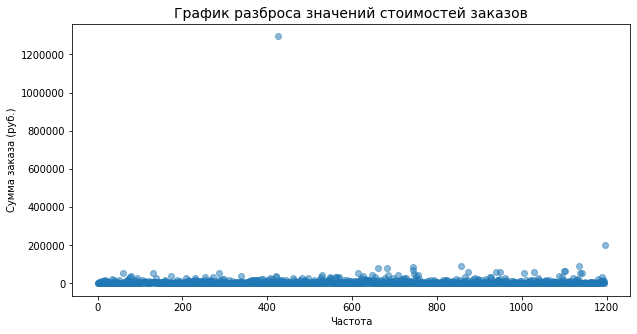

count      1197.000000
mean       8348.005848
std       39191.131774
min          50.000000
25%        1220.000000
50%        2978.000000
75%        8290.000000
max     1294500.000000
Name: revenue, dtype: float64

In [19]:
# строим гистограмму распределения значений стоимостей заказов

plt.figure(figsize=(10,5))
plt.hist(orders['revenue'], bins=50)
plt.xlabel('Сумма заказа (руб.)')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений стоимостей заказов', fontsize=14)
plt.show()

# строим график разброса значений

x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], alpha=0.5) 
plt.ylabel('Сумма заказа (руб.)')
plt.xlabel('Частота')
plt.title('График разброса значений стоимостей заказов', fontsize=14)
plt.show()

# дополнительно выведем на экран для наглядности числовое описание стоимостей заказов

pd.set_option('float_format', '{:f}'.format)
display(orders['revenue'].describe())

<div style="border:dotted black 3px; padding: 20px">

По данным графикам видим, что <b>в данных есть слишком дорогие заказы</b>, хоть и большая часть заказов лежит в одной области значений.<br><br>
    
Максимальная стоимость заказа  = 1 294 500 руб., при этом медиана всех заказов равна 2 978 руб. Из-за наличия выбросов средняя стоимость всех оформленных заказов стала больше медианы почти в 3 раза (8348 руб).<br><br>
       
Для точного отсечения аномальных пользователей в пределах 1%-5% наблюдений от общей массы нам необходимо рассчитать перцентили.
     
</div>

### 95-й и 99-й перцентили стоимости заказов

In [20]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

<div style="border:dotted black 3px; padding: 20px">

Не более, чем у 5% заказов чек дороже 28 000 руб.<br><br>
    
И не больше, чем у 1% заказов - дороже 58 233 руб.<br><br>
    
Будем считать <b>границей для отсеивания</b> аномальных заказов - <b>заказы стоимостью дороже 28 000 руб.</b>
    
</div>

### Статистическая значимость различий в конверсии («сырые» данные)

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным — без удаления аномальных пользователей.

Для определения статистической значимости нам необходимо подготовить сводный датафрейм, который будет содержать куммулятивные показатели. Сводный датафрейм будет содержать следующие столбцы:

- `date` — дата;

Заказы:
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `ordersCumulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `ordersCumulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;

Выручка:
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `revenueCumulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `revenueCumulativeB` — суммарная выручка до выбранной даты включительно в группе B;

Посетители/пользователи:
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCumulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCumulativeB` — количество пользователей до выбранной даты включительно в группе B.

Создадим для каждой группы А и B, соответственно, таблицы с количеством посетителей на определенный день `visitorsDaily `. И также создадим  для каждой группы А и B `visitorsCumulative` с кумулятивным показателем на определенный день.

In [21]:
# создаем для группы А

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACumulative = visitorsADaily \
.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']] \
.agg({'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1)
visitorsACumulative.columns = ['date', 'visitorsCumulativeA']

# теперь для группы B

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCumulative = visitorsBDaily \
.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']] \
.agg({'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1)
visitorsBCumulative.columns = ['date', 'visitorsCumulativeB']

Теперь создадим для каждой группы А и B, соответственно, таблицы с количеством заказов и выручкой на определенный день `ordersDaily `и `ordersCumulative` с кумулятивным показателем числа заказов и выручкой на определенный день.

In [22]:
# создаем для группы А

ordersADaily = orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']] \
.groupby('date', as_index=False).agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACumulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']] \
.agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])
ordersACumulative.columns = ['date', 'ordersCumulativeA', 'revenueCumulativeA']

# теперь для группы B

ordersBDaily = orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']] \
.groupby('date', as_index=False).agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCumulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']] \
.agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1).sort_values(by=['date'])
ordersBCumulative.columns = ['date','ordersCumulativeB','revenueCumulativeB']

Полученные 8 датафреймов объединим в один датафрейм по дате с помощью `.merge()`.

In [23]:
data = ordersADaily \
.merge(ordersBDaily, left_on='date', right_on='date', how='left') \
.merge(ordersACumulative, left_on='date', right_on='date', how='left') \
.merge(ordersBCumulative, left_on='date', right_on='date', how='left') \
.merge(visitorsADaily, left_on='date', right_on='date', how='left') \
.merge(visitorsBDaily, left_on='date', right_on='date', how='left') \
.merge(visitorsACumulative, left_on='date', right_on='date', how='left') \
.merge(visitorsBCumulative, left_on='date', right_on='date', how='left')

Создадим переменные `ordersByUsersA` и `ordersByUsersB` со столбцами `'userId'` и `'orders'`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [24]:
ordersByUsersA = orders[orders['group'] == 'A'].groupby('userId', as_index=False).agg({'orderId': pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group'] == 'B'].groupby('userId', as_index=False).agg({'orderId': pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders'] 

Необходимые операции почти сделаны. Сформулируем гипотезы.

**Сформулируем нулевую гипотезу H0:**

- H0: Cтатистически значимых различий в конверсии между группой A и группой B нет.

**Сформулируем альтернативную гипотезу H1:**

- H1: Есть статистически значимые различия в конверсии между группой A и группой B.

И, наконец, создадим выборки `sampleA` и `sampleB`, в которых пользователям из разных групп будет соответствовать количество заказов.

 - Число элементов в `sampleA` или в `sampleB` — это количество пользователей.
 - С помощью функции `pd.concat()` мы объединим 2 списка: 
  - 1-ый список с кол-вом заказов каждого пользователя `ordersByUsersA['orders']`;
  - и 2-ой список с нулями для пользователей, которые ничего не заказывали (нули - это есть разница между суммой посетителей и количеством записей о заказах) `data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])`.

Благодаря этим выборкам `sampleA` и `sampleB` мы найдем p-value и сможем рассчитать относительное различие в конверсиях.

Критический уровень статистической значимости  alpha выберем = 0.05 и считаем его допустимым, т.к. в гипотезах мы проверяем есть или нет статистически значимые различия в показателях, и у нас нет дополнительной информации от коммерческого департамента о возможных финансовых рисках, которые могли бы повлиять на наше решение снизить уровень значимости ниже 0.05.

In [25]:
# создаем  `sampleA` и `sampleB`

sampleA = \
pd.concat([ordersByUsersA['orders'], \
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleB = \
pd.concat([ordersByUsersB['orders'], \
pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0) 

# рассчитываем p-value c помощью "U-критерия Манна-Уитни" 

print("P-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, use_continuity=True, alternative = 'two-sided')[1]))
if stats.mannwhitneyu(sampleA, sampleB)[1] < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print()
print('-----------------------------------------------------------------------------------------------------------------------')

# и находим разницу в конверсии группы B

print("Относительное различие конверсии группы B = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


P-value = 0.017
Отвергаем нулевую гипотезу

-----------------------------------------------------------------------------------------------------------------------
Относительное различие конверсии группы B = 0.138


<div style="border:dotted black 3px; padding: 20px">
    
Из данного результата и отвержения H0 мы делаем вывод, что <b>по "сырым" данным есть статистически значимые различия в конверсии между группами А и B</b>. Относительный прирост конверсии группы B составил 13,8% по "сырым" данным.
    
</div>

### Статистическая значимость различий в среднем чеке заказа («сырые» данные)

Для расчёта статистической значимости различий в среднем чеке между сегментами, передадим критерию `mannwhitneyu()` данные о выручке с заказов. Также рассчитаем относительные различия в среднем чеке между группами.

**Сформулируем нулевую гипотезу H0:**

- H0: Cтатистически значимых различий в среднем чеке между группой A и группой B нет.

**Сформулируем альтернативную гипотезу H1:**

- H1: Есть статистически значимые различия в среднем чеке между группой A и группой B.

In [26]:
p_value_mean_check = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                                    orders[orders['group']=='B']['revenue'], \
                                                    use_continuity=True, alternative = 'two-sided')[1]

print('P-value = {0:.3f}'.format(p_value_mean_check))

if p_value_mean_check < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print()
print('-----------------------------------------------------------------------------------------------------------------------')
print('Относительное различие среднего чека группы B = {0:.3f}' \
.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 


P-value = 0.729
Не получилось отвергнуть нулевую гипотезу

-----------------------------------------------------------------------------------------------------------------------
Относительное различие среднего чека группы B = 0.259


<div style="border:dotted black 3px; padding: 20px">
    
Из данного результата мы делаем вывод, что <b>по "сырым" данным средний чек групп А и B статистически значимых различий не имеет</b>. Однако, при этом относительный прирост среднего чека в группе B по "сырым" данным составил 26%.<br><br>

</div>

**Приступим к очистке данных от аномальных пользователей.**

### Статистическая значимость различий в конверсии («очищенные» данные)

Сделаем срез пользователей `usersWithManyOrders` с аномально большим числом заказов >= 3 (как мы определили ранее).
А также срез `usersWithExpensiveOrders` с пользователями, совершившими аномально дорогие заказы > 28 000 руб (как мы определили ранее). 

Объединим их в таблицу `abnormalUsers`.

In [27]:
# для объединения списков c заказами А и В групп используем функцию `pd.concat()`
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] >= 3]['userId'], \
                                 ordersByUsersB[ordersByUsersB['orders'] >= 3]['userId']], axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['userId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

print("Всего аномальных пользователей найдено:", len(abnormalUsers)) 

Всего аномальных пользователей найдено: 74


Аналогично как в п.6.10. создадим 2 выборки с "очищенными" от аномалий данными: `sampleAFiltered` и `sampleBFiltered`, в которых пользователям из разных групп будет соответствовать количество заказов. 

Так же как и в п.6.10. с помощью функции `pd.concat()` объединим 2 списка: 

1) с количеством заказов каждого пользователя, **но** за исключением пользователей, попавших в категорию аномальных из списка `abnormalUsers` (для этого используем функцию `np.logical_not()` вместе с методом `.isin()`); 

2) список с нулями для пользователей, которые ничего не заказывали (нули - это есть разница между суммой посетителей и количеством записей о заказах) `data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])`.

Благодаря этим выборкам мы найдем p-value и сможем рассчитать относительное различие конверсии между группами.

In [28]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), \
name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), \
name='orders')], axis=0)

print("P-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, \
                                                    use_continuity=True, alternative = 'two-sided')[1]))

if stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, use_continuity=True, alternative = 'two-sided')[1] < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print()
print('-----------------------------------------------------------------------------------------------------------------------')
print("Относительное различие конверсии группы B = {0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))


P-value = 0.013
Отвергаем нулевую гипотезу

-----------------------------------------------------------------------------------------------------------------------
Относительное различие конверсии группы B = 0.173


<div style="border:dotted black 3px; padding: 20px">
    
Из данного результата и отвержения H0 мы делаем вывод, что **по "очищенным" данным (как и по "сырым" данным) есть статистически значимые различия в конверсии между группами А и B**. Относительный прирост конверсии группы B составил 17,3% по "очищенным" данным.
    
</div>

### Статистическая значимость различий в среднем чеке заказа («очищенные» данные)

Рассчитаем статистическую значимость различий в среднем чеке между группами. Аналогично как и в подсчете по "сырым" данным используем критерий `mannwhitneyu()`. Также рассчитаем относительные различия в среднем чеке между группами. 

In [29]:
p_value_mean_check_filtered = stats.mannwhitneyu( \
    orders[np.logical_and(orders['group']=='A', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'], \
    orders[np.logical_and(orders['group']=='B', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'], \
                                                 use_continuity=True, alternative = 'two-sided')[1]

mean_check_distinction_filtered = orders[np.logical_and(orders['group']=='B', \
    np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean() / \
    orders[np.logical_and(orders['group']=='A', np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue'].mean() - 1


print("P-value = {0:.3f}".format(p_value_mean_check_filtered))
if p_value_mean_check_filtered < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print()
print('----------------------------------------------------------------------------------------------------------')
print("Относительное различие среднего чека группы B = {0:.3f}".format(mean_check_distinction_filtered))

P-value = 0.738
Не получилось отвергнуть нулевую гипотезу

----------------------------------------------------------------------------------------------------------
Относительное различие среднего чека группы B = -0.020


<div style="border:dotted black 3px; padding: 20px">
    
Из данного результата мы делаем вывод, что <b>по "очищенным" данным средний чек групп А и B не имеет статистически значимых различий</b>. При этом относительный прирост среднего чека в группе А по "сырым" данным составил 2%.
       
</div>

## Общий вывод

<div style="border: ridge black 3px; padding: 25px">
    
В ходе приоритизации гипотез с помощью фреймворка RICE была выявлена топовая гипотеза (RICE = 112) "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".<br><br>
    
<b>По результатам проведенного анализа А/B-теста рекомендуем принять следующее решение:</b><br><br>
    
<b>Остановить тест и зафиксировать победу группы B.</b><br>
<hr>
В ходе анализа было определено следующее:<br><br>

1) Найдено 74 аномальных пользователя, влияние которых отразилось на графике кумулятивной выручки и графике среднего чека в пользу группы B по "сырым" данным.<br>
    
2) График кумулятивной конверсии по "сырым" данным зафиксировал лидирующее положение группы B.<br>
    
3) Как по "сырым", так и по "очищенным" данным есть статистически значимые различия в конверсии между группами.<br>
    
4) Относительный прирост конверсии группы B по "сырым" данным составил 13,8%; по "очищенным" данным 17,3%.<br>

5) Как по "сырым", так и по "очищенным" данным отсутствуют статистически значимые различия в среднем чеке между группами (при этом относительный прирост среднего чека в группе B по "сырым" данным составил 26%; по "очищенным" 2%).<br>
    
</div>